In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

%matplotlib inline
import time
import pylab as pl
from IPython import display

import seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap
pd.options.display.float_format = "{:,.3f}".format

In [2]:
# Check if CUDA is available and set PyTorch to use the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
rng = np.random.default_rng()

In [4]:
%run ../utils/create_trials.py "AB","BC","CD","DE","EF","FG" # LS train structure
# %run ../utils/create_trials.py "AB","AC","AD","AE","AF","AG" # OTM train structure
# %run ../utils/create_trials.py "BA","CA","DA","EA","FA","GA" # MTO train structure


Trainig pairs for the experiment ['AB', 'BC', 'CD', 'DE', 'EF', 'FG']
Creating experiment with 7 members, 4 classes and 21 dummy stimulus.
Experiment trials created!


In [5]:
%run ../utils/results_explore.py

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

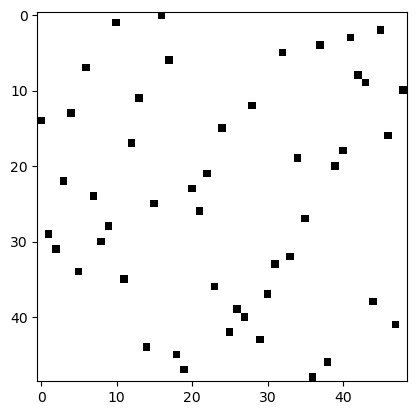

In [6]:
plt.imshow(stims.values(), cmap='Greys')

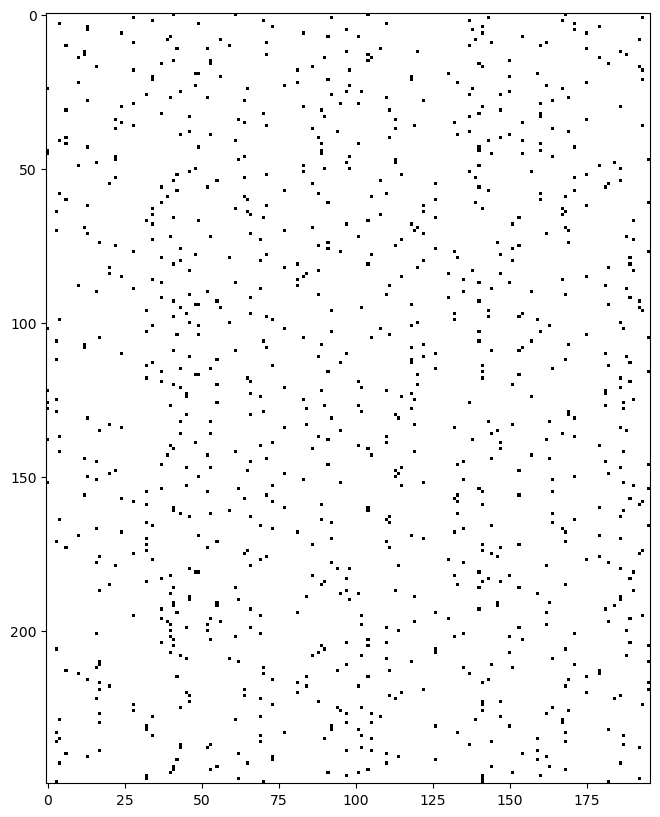

,sample_subset,st_sample,st_comp1,st_comp2,st_comp3,option_answer,st_comparison
4105,train,A4,E2,B4,G3,O_2,B4
16256,train,D1,C2,A3,E1,O_3,E1
24521,train,E4,G3,F1,F4,O_3,F4
16405,train,D2,D3,E2,D4,O_2,E2
14916,train,C4,D4,C2,B2,O_1,D4
...,...,...,...,...,...,...,...
3925,train,A4,D2,B4,G3,O_2,B4
23761,train,E3,C1,F3,D2,O_2,F3
7513,train,B2,C3,C2,C4,O_2,C2
6592,train,B2,C4,C2,A3,O_2,C2


In [7]:
random_sel_idx=rng.choice(len(exper_info['train']['values']), 250) 
plt.figure(figsize=(10,10))
plt.imshow(exper_info['train']['values'][random_sel_idx], cmap='Greys')
plt.show()
exper_info['train']['info'].iloc[random_sel_idx,]

In [8]:
train_trials = exper_info['train']['values']
train_answers = exper_info['train']['answers']

############# inputs for trainning the agent
input_trials = train_trials  # Replace with actual trial data
input_responses = train_answers  # Replace with actual response data

## Hyperparameters
batch_size = 128 #64  # Batch size for sampling from the replay buffer
alpha=0.01 
gamma=0.99 # not required # one single action to reach terminal state
epsilon= 1/2

## n_states = len(train_trials)  # Number of possible encoded training trials
n_dim_state = input_trials.shape[1] # number of features on state (1-d array)
n_actions = 3  # Assuming 3 comparison stimuli

## max iter training loop
n_episodes=25


In [9]:
# Define the DQN architecture
# one layer of 50k units seems a sweet spot.
class DQNAgent(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNAgent, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 50000),
            nn.ReLU(),
            # nn.Linear(15000, 15000),
            # nn.ReLU(),
            nn.Linear(50000, output_dim)
        ).to(device)
    
    def forward(self, state):
        return self.network(state)

# Function to choose the best action from the Q-values
def choose_best_action(agent, state):
    with torch.no_grad():
        q_values = agent(state.to(device))  # Move the state to GPU if available
        best_action = torch.argmax(q_values).item()
    return best_action

In [10]:
# Initialize the DQN agent
dqn_agent = DQNAgent(input_dim=n_dim_state, output_dim=n_actions).to(device)
print(sum(p.numel() for p in dqn_agent.parameters())/1e6, 'M parameters')
# Define the optimizer
optimizer = optim.Adam(dqn_agent.parameters(), lr=0.001)

# Define the loss function
criterion = nn.MSELoss()

# Experience replay buffer
replay_buffer = deque(maxlen=10000)

# Function to add experience to the replay buffer
def add_experience(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))

# Function to sample experiences from the replay buffer
def sample_experiences(batch_size):
    indices = rng.choice(len(replay_buffer), size=batch_size, replace=False)
    return [replay_buffer[idx] for idx in indices]

# Function to train the DQN agent
def train_dqn(batch_size):
    if len(replay_buffer) < batch_size:
        return
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = zip(*experiences)
    
    # Convert lists of numpy.ndarrays to a single numpy.ndarray
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)
    
    # Now convert numpy.ndarrays to PyTorch tensors
    states = torch.tensor(states, device=device, dtype=torch.float32)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float32)
    dones = torch.tensor(dones, device=device, dtype=torch.uint8)
    
    current_q_values = dqn_agent(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
    next_q_values = dqn_agent(next_states).max(1)[0]
    expected_q_values = rewards + (1 - dones) * gamma * next_q_values
    
    loss = criterion(current_q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

10.000003 M parameters


C:\ProgramData\anaconda3\envs\experims\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
train_accuracy =.0
train_accuracy_episodes = []
# Training loop
episode = 0
while (train_accuracy < 1-1e-4)&(episode < n_episodes):
    # Randomize trials at the start of each episode
    indices = np.arange(input_trials.shape[0])
    rng.shuffle(indices)
    
    for idx in indices:
        state = input_trials[idx]
        state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
        action = choose_best_action(dqn_agent, state_tensor)
        
        # Determine the reward based on the response array
        reward = input_responses[idx, action]
        
        # Since each trial is independent, next_state is not used
        next_state = state_tensor
        done = True  # Each trial is terminal
        
        # Add experience to replay buffer
        add_experience(state, action, reward, state, done)
        
        # Train the DQN agent
        train_dqn(batch_size)

    agent_actions=[] 
    for trial in input_trials:
        state = torch.tensor(trial, dtype=torch.float32)
        # Choose the best action
        best_action = choose_best_action(dqn_agent, state)
        agent_actions.append(best_action)
    
    train_predictions = np.array(agent_actions)
    train_responses = np.argmax(input_responses, axis=1)
    train_accuracy = sum(train_predictions == train_responses ) / len(train_predictions)
    train_accuracy_episodes.append(train_accuracy)
    display.clear_output()
    print(f"Episode {episode + 1}/{n_episodes} completed, {train_accuracy:.4f}")
    episode += 1
else:
    print(f"Train completed in {episode}/{n_episodes} episodes with {train_accuracy:.4f} accuracy")

Episode 3/25 completed, 1.0000
Train completed in 4/25 episodes with 1.0000 accuracy


[0.999537037037037, 0.9974206349206349, 1.0]


(0.0, 1.1)

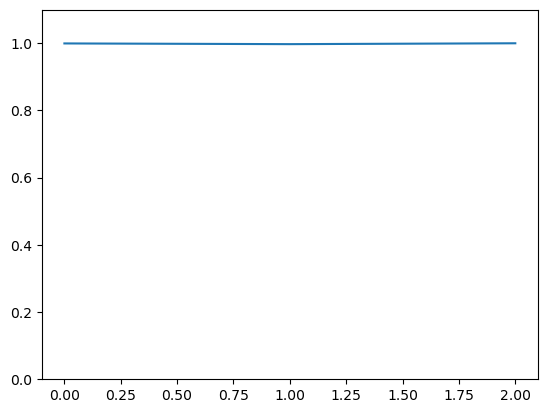

In [12]:
print(train_accuracy_episodes)
plt.plot(range(len(train_accuracy_episodes)), train_accuracy_episodes)
plt.ylim(0,1.1)

In [13]:
###### Evaluation sets

In [14]:
test_set_list = ["train", 'reflexivity', 'symmetry', 'transitivity']
evaluation_info = pd.DataFrame(columns= [
    'sample_subset', 
    'st_sample',
    'st_comp1',
    'st_comp2',
    'st_comp3',
    'option_answer',
    'st_comparison',
    'agent_response',
    'sample_member',
    'comparison_member', 
    'response_score'])

for eval_set in test_set_list:
    test_trials = exper_info[eval_set]['values']
    test_answers = exper_info[eval_set]['answers']
    test_info = exper_info[eval_set]['info']
    
    test_actions = [] 
    for trial in test_trials:
        state = torch.tensor(trial, dtype=torch.float32)
        # Choose the best action
        best_action = choose_best_action(dqn_agent, state)
        test_actions.append(best_action)
    test_predictions = np.array(test_actions)
    test_responses = np.argmax(test_answers, axis=1)
    response_score = (test_predictions == test_responses ) * 1 
    test_info['sample_member']=[stim[0] for stim in test_info.st_sample]
    test_info['comparison_member']=[stim[0] for stim in test_info.st_comparison]
    test_info['agent_response'] = test_actions
    test_info['response_score'] = response_score
    test_info.loc[test_info.sample_subset=="train_dummy","sample_subset"]="train"
    evaluation_info = pd.concat([evaluation_info, test_info], ignore_index=True)

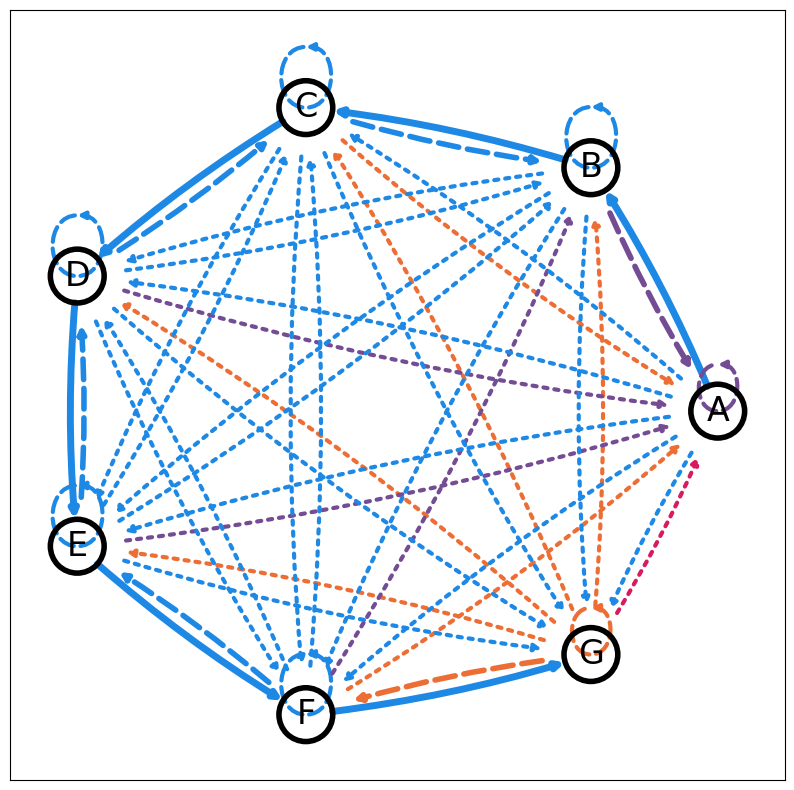

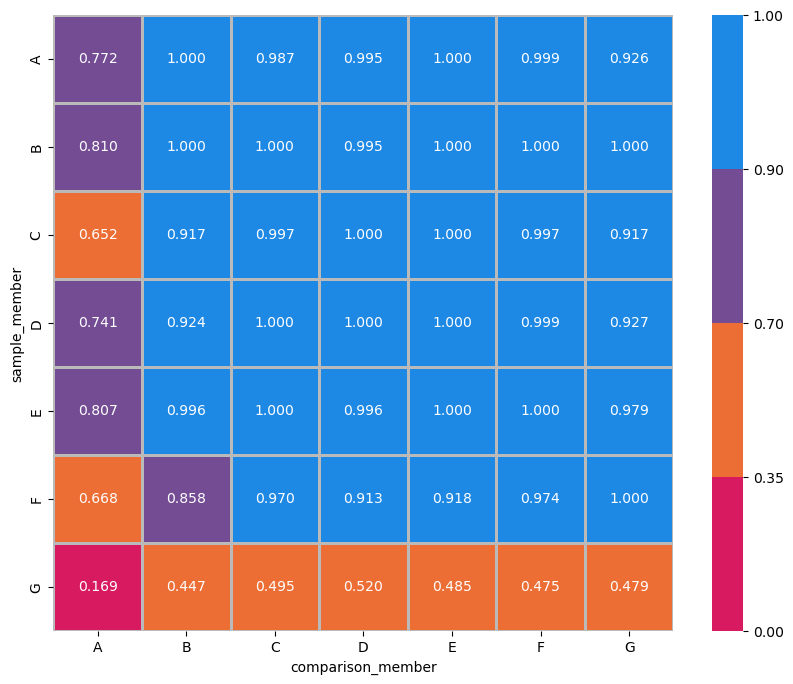

comparison_member,A,B,C,D,E,F,G
sample_member,,,,,,,
A,0.772,1.000,0.987,0.995,1.000,0.999,0.926
B,0.810,1.000,1.000,0.995,1.000,1.000,1.000
C,0.652,0.917,0.997,1.000,1.000,0.997,0.917
D,0.741,0.924,1.000,1.000,1.000,0.999,0.927
E,0.807,0.996,1.000,0.996,1.000,1.000,0.979
F,0.668,0.858,0.970,0.913,0.918,0.974,1.000
G,0.169,0.447,0.495,0.520,0.485,0.475,0.479


In [15]:
evaluation_graph_dat = get_agent_graph_dat(
    agent_info_df = evaluation_info, 
    metric_column = "response_score"
)
evaluation_graph_dat.response_score = evaluation_graph_dat.response_score.astype("float")

plot_graph_results(
    graph_dat_plot = evaluation_graph_dat, 
    metric_column = "response_score",
    node_origin = "sample_member",
    node_destiny = "comparison_member",
    trial_group = "sample_subset",
    minimal_cut_value = .9,
    random_level = .35
)

plot_heatmap_dat(
    graph_dat_plot = evaluation_graph_dat, 
    metric_column = "response_score",
    minimal_cut_value = .9,
    random_level = .35
)